In [1]:
import pandas as pd
import gc
import numpy as np

In [2]:
# reemplazar con la dirección del archivo descargado
products = pd.read_csv('C:\\Users\\Usuario\\Downloads\\archive\\products.csv') 
train_orders = pd.read_csv('C:\\Users\\Usuario\\Downloads\\archive\\order_products__train.csv', nrows= 200000)
# las ordenes prior tienen mas de 30 millones de filas, para reducir intentamos con 1 millon
prior_orders = pd.read_csv('C:\\Users\\Usuario\\Downloads\\archive\\order_products__prior.csv', nrows= 1000000) 
orders = pd.read_csv('C:\\Users\\Usuario\\Downloads\\archive\\orders.csv')
#aisles = pd.read_csv('C:\\Users\\Usuario\\Downloads\\archive\\aisles.csv')
#departments = pd.read_csv('C:\\Users\\Usuario\\Downloads\\archive\\departments.csv')

In [3]:
print(orders.columns)

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')


In [4]:
print(orders.columns)
print(prior_orders.columns)

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')
Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object')


In [5]:
orders_past = orders[orders["eval_set"] == "prior"]
orders_past = orders_past.drop(["eval_set"], axis=1)
# juntamos toda la información de cada orden en un data frame
prior = prior_orders.merge(orders_past, on="order_id", how="left")

In [6]:
# usamos estas funciones para ahorrar espacio
# cuando no necesitamos más un data frame, lo borramos
del prior_orders, orders_past
gc.collect()

404

In [7]:
orders_present = orders[orders["eval_set"]== "train"]
orders_present = orders_present.drop(["eval_set"], axis=1)
present = train_orders.merge(orders_present, on="order_id", how="left")

In [8]:
del train_orders, orders, orders_present
gc.collect()

0

In [9]:
# vemos los usuarios que tenemos en comun entre las ordenes pasada y las actuales
common_users = set(present['user_id']).intersection(set(prior['user_id']))

In [ ]:
# nos quedamos solo con esos usuarios (solo usar si no se quiere intentar predecir en usuarios nuevos)
present = present[present['user_id'].isin(common_users)]
prior = prior[prior['user_id'].isin(common_users)]

In [10]:
print(len((present['user_id']).unique()))
print(len((prior['user_id']).unique()))
print(len(common_users))

18926
67036
6282


In [ ]:
# para saber las dimensiones de nuestro data frame 
# habrán cambiado si es que nos quedamos con los usuarios en común solamente
print(present.shape)
print(prior.shape)

(200000, 9)
(1000000, 9)


In [ ]:
# Count how many times each user-product pair appears
user_product_counts = prior.groupby(['user_id', 'product_id']).size()

# Identify first-time purchases (should be where count == 1 and reordered == 0)
first_time_purchases = prior[(prior['reordered'] == 0)]

# See if there are any reordered = 0 where the user has bought the product before
# (i.e., check for any inconsistencies)
reordered_zero_duplicates = first_time_purchases.duplicated(subset=['user_id', 'product_id'], keep=False)

print(reordered_zero_duplicates.any())  # Should be False if reordered=0 means first-time


In [ ]:
# estas columnas podrían ser muy influyentes
# la mayoría de nuestros negativos serán combinaciones de usuario-producto no existentes previamente
present = present.drop('order_number', axis = 1)
prior = prior.drop('order_number', axis = 1)
present = present.drop('reordered', axis = 1)
prior = prior.drop('reordered', axis = 1)

In [13]:
print(present.columns)
print(prior.columns)

Index(['order_id', 'product_id', 'add_to_cart_order', 'user_id', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')
Index(['order_id', 'product_id', 'add_to_cart_order', 'user_id', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')


In [ ]:
# creamos filas flasas basadas en las filas reales
def sample_negatives_per_user(present_orders_df, all_products, n_neg=5):
    user_to_products = present_orders_df.groupby('user_id')['product_id'].apply(set).to_dict()
    user_context = present_orders_df.drop_duplicates('user_id').set_index('user_id')[
        ['order_id', 'order_hour_of_day', 'order_dow', 'add_to_cart_order', 'days_since_prior_order']
    ].to_dict('index')

# estas se crearán a partir de la diferencia entre todos los productos y los que si compró el usuario
    negatives = []
    for user, bought_prods in user_to_products.items():
        candidates = list(all_products - bought_prods)
        sampled = np.random.choice(candidates, size=min(n_neg, len(candidates)), replace=False)
        context = user_context[user]
        for prod in sampled:
            negatives.append({
                'order_id': context['order_id'],
                'product_id': prod,
                'add_to_cart_order': context['add_to_cart_order'],
                'user_id': user,
                'order_dow': context['order_dow'],
                'order_hour_of_day': context['order_hour_of_day'],
                'days_since_prior_order': context['days_since_prior_order'],
                'label': 0
            })
    return pd.DataFrame(negatives)


In [ ]:
# Positivas
pos_df = present
pos_df['label'] = 1

# Negativas
all_products = set(products['product_id'].unique())
neg_df = sample_negatives_per_user(present, all_products, n_neg=5)

# Combinar
combined = pd.concat([pos_df, neg_df], ignore_index=True)


In [18]:
del pos_df, products, neg_df, present
gc.collect()

750

In [19]:
# Product features
product_feats = prior.groupby('product_id').agg(
    prod_total_orders=('order_id', 'count'),
    prod_common_cart_position=('add_to_cart_order', lambda x: x.mode().iloc[0]),
    prod_common_hour=('order_hour_of_day', lambda x: x.mode().iloc[0]),
    prod_avg_hour=('order_hour_of_day', 'mean'),
    prod_std_hour=('order_hour_of_day', 'std'),
    prod_common_day=('order_dow', lambda x: x.mode().iloc[0])
).reset_index()

In [ ]:
# features de interacciones entre usuario y producto
user_prod_feats = prior.groupby(['user_id', 'product_id']).agg(
    most_common_day=('order_dow', lambda x: x.mode().iloc[0]),
    common_hour = ('order_hour_of_day', lambda x: x.mode().iloc[0]),
    avg_hour = ('order_hour_of_day', 'mean'),
    std_hour = ('order_hour_of_day', 'std'),
    order_count=('order_id', 'count'),
    common_cart_pos=('add_to_cart_order', lambda x: x.mode().iloc[0]),
    avg_days_between_orders=('days_since_prior_order', 'mean'),
    std_days_between_orders=('days_since_prior_order', 'std')
).reset_index()

In [21]:
combined = combined.merge(user_prod_feats, on=['user_id', 'product_id'], how='left')
combined = combined.merge(product_feats, on='product_id', how='left')

In [22]:
del user_prod_feats, product_feats
gc.collect()

0

In [ ]:
combined.fillna(0, inplace=True)  # reemplazar con 0 los valores vacíos donde nunca hubo tal combinación de usuario y producto

In [ ]:
df = combined

# creamos nuevas features que dan una nota en base a que tan similares son 
# las características de ordenes pasadas a las características de las actuales

# features de usuario-producto
df['match_common_hour'] = abs(df['order_hour_of_day'] - df['common_hour']).astype(int)
df['match_days_between'] = abs(df['days_since_prior_order'] - df['avg_days_between_orders']).astype(int)
df['within_days_std'] = (
    (df['days_since_prior_order'] >= df['avg_days_between_orders'] - df['std_days_between_orders']) &
    (df['days_since_prior_order'] <= df['avg_days_between_orders'] + df['std_days_between_orders'])
).astype(int)
df['match_most_common_day'] = abs(df['order_dow'] - df['most_common_day']).astype(int)
df['match_common_cart_pos'] = abs(df['add_to_cart_order'] - df['common_cart_pos']).astype(int)
df['match_avg_hour'] = abs(df['order_hour_of_day'] - df['avg_hour']).astype(int)
df['within_hour_std'] = (
    (df['order_hour_of_day'] >= df['avg_hour'] - df['std_hour']) &
    (df['order_hour_of_day'] <= df['avg_hour'] + df['std_hour'])
).astype(int)
df['user_strength'] = df['order_count'] / df['order_count'].max()


# features específicas al producto
df['match_prod_common_cart_pos'] = abs(df['add_to_cart_order'] - df['prod_common_cart_position']).astype(int)
df['match_prod_common_hour'] = abs(df['order_hour_of_day'] - df['prod_common_hour']).astype(int)
df['match_prod_avg_hour'] = abs(df['order_hour_of_day'] - df['prod_avg_hour']).astype(int)
df['match_prod_common_day'] = abs(df['order_dow'] - df['prod_common_day']).astype(int)
df['within_prod_hour_std'] = (
    (df['order_hour_of_day'] >= df['prod_avg_hour'] - df['prod_std_hour']) &
    (df['order_hour_of_day'] <= df['prod_avg_hour'] + df['prod_std_hour'])
).astype(int)
df['product_strength'] = df['prod_total_orders'] / df['prod_total_orders'].max()

In [25]:
del combined, prior
gc.collect()

0

In [ ]:
# usar para ver que dataframes están en la memoria en el momento, su peso y sus dimensiones
# en este punto solo se necesita df
for name, obj in globals().items():
    if isinstance(obj, pd.DataFrame):
        print(f"\n===== DataFrame: {name} =====")
        print(f"Shape: {obj.shape}")
        print(f"Memory usage: {obj.memory_usage().sum() / 1024**2:.2f} MB")


===== DataFrame: df =====
Shape: (294630, 36)
Memory usage: 80.92 MB


In [ ]:
print(df.columns) # vemos las columnas

Index(['order_id', 'product_id', 'add_to_cart_order', 'user_id', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'label',
       'most_common_day', 'common_hour', 'avg_hour', 'std_hour', 'order_count',
       'common_cart_pos', 'avg_days_between_orders', 'std_days_between_orders',
       'prod_total_orders', 'prod_common_cart_position', 'prod_common_hour',
       'prod_avg_hour', 'prod_std_hour', 'prod_common_day',
       'match_common_hour', 'match_days_between', 'within_days_std',
       'match_most_common_day', 'match_common_cart_pos', 'match_avg_hour',
       'within_hour_std', 'match_prod_common_cart_pos',
       'match_prod_common_hour', 'match_prod_avg_hour',
       'match_prod_common_day', 'within_prod_hour_std', 'user_strength',
       'product_strength'],
      dtype='object')


In [ ]:
# quitamos todas las columnas menos las que dan un puntaje de similitud
training_df = df.drop(['order_id', 'add_to_cart_order', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'most_common_day', 'common_hour',
       'avg_hour', 'std_hour', 'order_count', 'common_cart_pos',
       'avg_days_between_orders', 'std_days_between_orders', 'prod_total_orders',
       'prod_common_cart_position', 'prod_common_hour', 'prod_avg_hour',
       'prod_std_hour', 'prod_common_day', 'user_strength'], axis = 1)
del df
gc.collect()

0

In [ ]:
print(training_df.columns)

Index(['product_id', 'user_id', 'label', 'match_common_hour',
       'match_days_between', 'within_days_std', 'match_most_common_day',
       'match_common_cart_pos', 'match_avg_hour', 'within_hour_std',
       'match_prod_common_cart_pos', 'match_prod_common_hour',
       'match_prod_avg_hour', 'match_prod_common_day', 'within_prod_hour_std',
       'product_strength'],
      dtype='object')


In [ ]:
# si uno quiere que solo tomando en cuenta las características del producto
#training_df = training_df.drop(['match_common_hour',
#       'match_days_between', 'within_days_std', 'match_most_common_day',
#       'match_common_cart_pos', 'match_avg_hour', 'within_hour_std'],axis = 1)

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# mantenemos una copia de estas dos columnas por si se quiera hacer un análisis mas tarde
meta = training_df[['user_id', 'product_id']].copy()

# creamos las training features y labels 
features = [col for col in training_df.columns if col not in ['user_id', 'product_id', 'label']]
X = training_df[features]
y = training_df['label']

# Train/test split 
X_train, X_val, y_train, y_val, meta_train, meta_val = train_test_split(
    X, y, meta, stratify=y, test_size=0.2, random_state=42
)


train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'num_leaves': 63,
    'learning_rate': 0.05,
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[val_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=40),
        lgb.log_evaluation(period=10)
    ]
)




Training until validation scores don't improve for 40 rounds
[10]	valid_0's auc: 0.993663
[20]	valid_0's auc: 0.993691
[30]	valid_0's auc: 0.993708
[40]	valid_0's auc: 0.993712
[50]	valid_0's auc: 0.99373
[60]	valid_0's auc: 0.993733
[70]	valid_0's auc: 0.993798
[80]	valid_0's auc: 0.993796
[90]	valid_0's auc: 0.993783
[100]	valid_0's auc: 0.993791
Did not meet early stopping. Best iteration is:
[70]	valid_0's auc: 0.993798


In [ ]:
X_val['pred_score'] = model.predict(X_val[features]) 

In [41]:
print(y_val.head())

111150    1
181222    1
209136    0
199244    1
266635    0
Name: label, dtype: int64


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# predice 0 o 1 usando 0.5 como límite
X_val['pred_label'] = (X_val['pred_score'] >= 0.5).astype(int)

# Ground truth
y_true = y_val.values
y_pred = X_val['pred_label'].values
y_score = X_val['pred_score'].values

# evaluar el modelo
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("ROC AUC:", roc_auc_score(y_true, y_score))  # usar puntaje real


Accuracy: 0.9673828191290772
Precision: 0.9854411014788373
Recall: 0.966225
F1 Score: 0.9757384498863924
ROC AUC: 0.9937981295572228


In [ ]:
y_val.value_counts(normalize=True) # nos aseguramos de que sea balanceado el data set


label
1    0.678817
0    0.321183
Name: proportion, dtype: float64

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

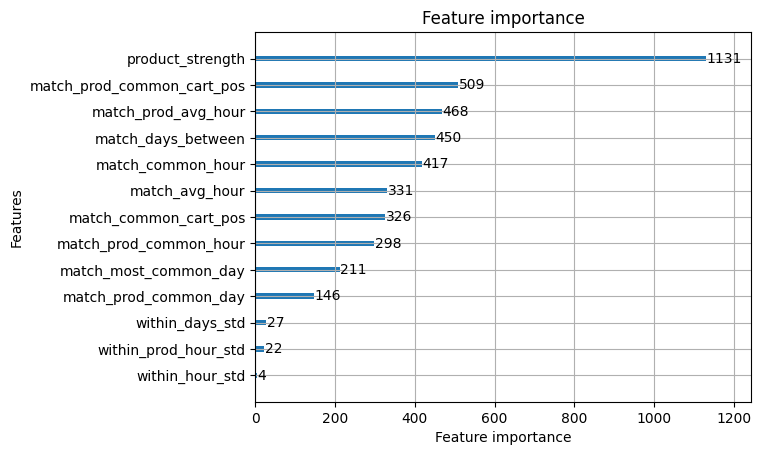

In [ ]:
lgb.plot_importance(model, importance_type='split')  # importancia de las features en base a particiones



<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

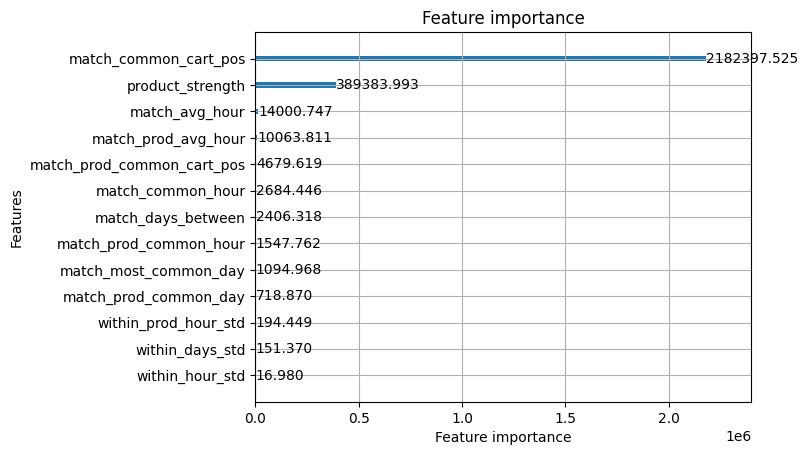

In [ ]:
lgb.plot_importance(model, importance_type='gain')   # en base a ganacia